# ESPEI

## Goals

1. Provide a working example of parameter selection from single phase data 
2. Show how to run MCMC (we won't run it here)
3. Discuss examples of how to analyze results with using pycalphad and ESPEI

All of this will be shown through the Jupyter Notebook, however there are command line equivalents for running ESPEI (but not analyzing results). For more details on the command line interface, please see [ESPEI.org](http://espei.org/) or the provided PDF documention ([link to online PDF](http://readthedocs.org/projects/espei/downloads/pdf/latest/) and [Epub](http://readthedocs.org/projects/espei/downloads/epub/latest/))


## Notes about files

ESPEI input files are either stored as `JSON` files or `YAML` files. Both of these are common machine readable formats based on key-value pairs. 

[JSON tutorial](https://learnxinyminutes.com/docs/json/)
[YAML tutorial](https://learnxinyminutes.com/docs/yaml/)

## Fitting to single phase data


### `Cu-Mg_phases.json`

The Cu-Mg system has the following phases, which we will treat with the following sublattice models

```
LIQUID:    (CU, MG)1
FCC_A1:    (CU, MG)1
HCP_A3:    (CU, MG)1
LAVES_C15: (CU, MG)2 (CU, MG)1
CUMG2:     (CU)1 (MG)2
```

The `Cu-Mg_phases.json` file (copied below) shows how these are encoded. 

```
{
  "components": ["CU", "MG", "VA"],
  "phases": {
         "LIQUID" : {
            "sublattice_model": [["CU", "MG"]],
            "sublattice_site_ratios": [1]
         },
         "CUMG2": {
            "sublattice_model": [["CU"], ["MG"]],
            "sublattice_site_ratios": [1, 2]
         },
         "FCC_A1": {
            "sublattice_model": [["CU", "MG"]],
            "sublattice_site_ratios": [1]
         },
         "HCP_A3": {
            "sublattice_site_ratios": [1],
            "sublattice_model": [["CU", "MG"]]
         },
         "LAVES_C15": {
            "sublattice_site_ratios": [2, 1],
            "sublattice_model": [["CU", "MG"], ["CU", "MG"]]
         }
    }
}
```

*Note that even the single element sublattices have brackets around them.* 

### Datasets

Datasets that will be used for the fitting are found in the `input_data` folder. Any file that ends in `.json` will be detected as a dataset. You can organize these files however you like and include other files alongside them, such as spreadsheets and original PDFs.

Examples are found at http://espei.org/en/latest/input_data.html or in section 4.2 of the documentation.

### `espei_input.yaml`

All interaction with running ESPEI happens through ESPEI input files. The ESPEI input file is in the `YAML` format. 

The different input keywords are described [online](http://espei.org/en/latest/writing_input.html) or in section 6.1.1 of the documentation. 

We'll repeat the YAML file below and load it from Python.

In [1]:
import yaml
espei_input_yaml = yaml.load("""
system:
  phase_models: Cu-Mg_phases.json       # path to the phases file
  datasets: input-data/param_gen_data   # path to the directory containing input data
generate_parameters:
  excess_model: linear                  # what type of parameters to generate
  ref_state: SGTE91                     # which reference state to use
output:
  output_db: my_cu-mg.tdb               # what to name the output TDB file
  verbosity: 1                          # levels of verbosity. Choose 0, 1 or 2 for Warnings, Info, or Debug
""")

### Running ESPEI

To run ESPEI, we simply import the `run_espei` function and pass the dictionary of input we loaded. To run this from the command line run:

```
$ espei --input espei_input.yaml
```

The function returns a pycalphad `Database`, but also writes the parameter selected database to file.

In [2]:
from espei import run_espei
dbf = run_espei(espei_input_yaml)

INFO:root:Generating parameters.
INFO:root:FITTING: CUMG2
INFO:root:FITTING: FCC_A1
INFO:root:FITTING: HCP_A3
INFO:root:FITTING: LAVES_C15
INFO:root:FITTING: LIQUID
INFO:root:Finished generating parameters.


## Comparing the selected parameters to data

Text(0.5,1,'LIQUID Mixing')

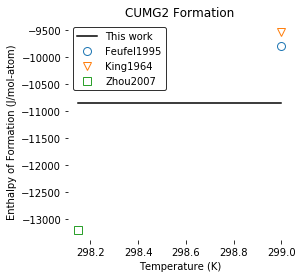

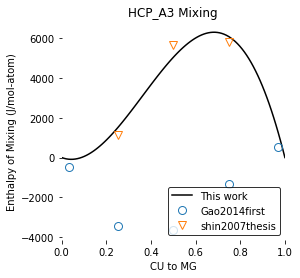

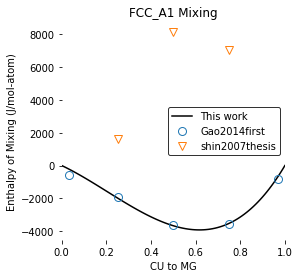

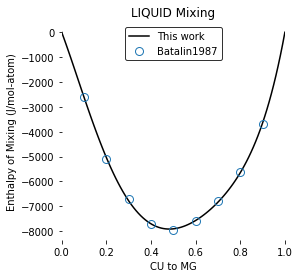

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# load the datasets by hand
from espei.datasets import recursive_glob, load_datasets
datasets = load_datasets(recursive_glob('input-data/all-data', '*.json'))

# import espei plotting code
from espei.plot import multiplot, plot_parameters

comps = ['CU', 'MG', 'VA']
phases = ['CUMG2', 'FCC_A1', 'HCP_A3', 'LAVES_C15', 'LIQUID']


# Make the plots
plot_parameters(dbf, comps, 'CUMG2', ('CU', 'MG'), symmetry=None, datasets=datasets)
plt.title('CUMG2 Formation')
plot_parameters(dbf, comps, 'HCP_A3', (('CU', 'MG'),), symmetry=None, datasets=datasets)
plt.title('HCP_A3 Mixing')
plot_parameters(dbf, comps, 'FCC_A1', (('CU', 'MG'),), symmetry=None, datasets=datasets)
plt.title('FCC_A1 Mixing')
plot_parameters(dbf, comps, 'LIQUID', (('CU', 'MG'),), symmetry=None, datasets=datasets)
plt.title('LIQUID Mixing')


(600, 1400)

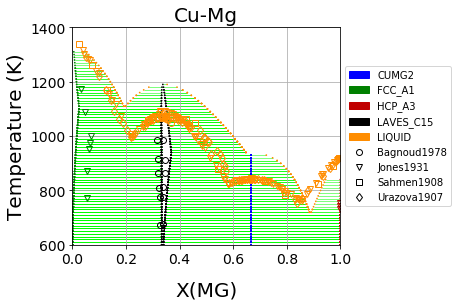

In [4]:
# import the pycalphad code that we need to specify conditions
from pycalphad import variables as v

multiplot(dbf, comps, phases, {v.P: 101325, v.T: (600, 1400, 10), v.X('MG'): (0, 1, 0.05)}, datasets)
plt.xlim(0, 1)
plt.ylim(600, 1400)

## Adding data

Before we only fit endmember data of the Laves phase.

Now imagine that we have done some DFT calculations using special quasirandom structures and want to add that data to our dataset. We created the file `CU-MG-HM_MIX-LAVES_C15-DFT.json` with our data and added it to `input-data/param_gen_data_laves/LAVES_C15` folder. 

We'll use ESPEI to generate parameters again, this time setting the YAML file to point to the new data folder containing the new data.

In [5]:
espei_input_yaml = yaml.load("""
system:
  phase_models: Cu-Mg_phases.json            # path to the phases file
  datasets: input-data/param_gen_data_laves  # path to the directory containing input data
generate_parameters:
  excess_model: linear                       # what type of parameters to generate
  ref_state: SGTE91                          # which reference state to use
output:
  output_db: my_cu-mg.tdb                    # what to name the output TDB file
  verbosity: 1                               # levels of verbosity. Choose 0, 1 or 2 for Warnings, Info, or Debug
""")

In [6]:
dbf = run_espei(espei_input_yaml)

INFO:root:Generating parameters.
INFO:root:FITTING: CUMG2
INFO:root:FITTING: FCC_A1
INFO:root:FITTING: HCP_A3
INFO:root:FITTING: LAVES_C15
INFO:root:FITTING: LIQUID
INFO:root:Finished generating parameters.


And finally look at the new data and phase diagram.

Text(0.5,1,'LAVES CU:CU,MG')

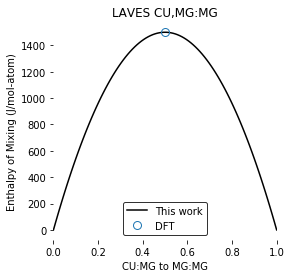

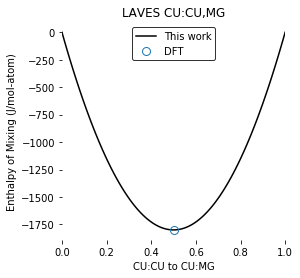

In [7]:
plot_parameters(dbf, comps, 'LAVES_C15', (('CU', 'MG'), 'MG'), symmetry=None, datasets=datasets)
plt.title('LAVES CU,MG:MG')
plot_parameters(dbf, comps, 'LAVES_C15', ('CU', ('CU', 'MG')), symmetry=None, datasets=datasets)
plt.title('LAVES CU:CU,MG')

(600, 1400)

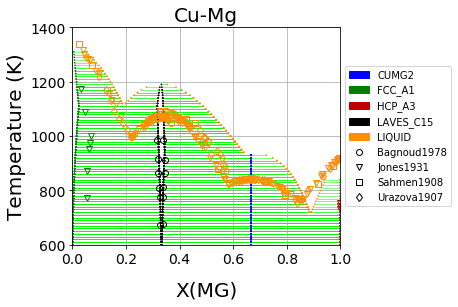

In [8]:
multiplot(dbf, comps, phases, {v.P: 101325, v.T: (600, 1400, 10), v.X('MG'): (0, 1, 0.05)}, datasets)
plt.xlim(0, 1)
plt.ylim(600, 1400)